# Evaluating Subcluster Reproducibility in MULTIVI-Splice Latent Spaces  
This notebook demonstrates how to load a pre-trained MULTIVI-Splice model and its MuData object, extract joint, expression-only, and splicing-only embeddings for a chosen cell type (e.g. Microglia), split the cells in two, cluster the first half, assign those cluster labels to the second half, train a simple classifier on the second half, and then evaluate cluster consistency on the first half using accuracy, ARI, and NMI.


## 1. Imports & Configuration

In [61]:
import os
import random
import numpy as np
import pandas as pd
import scanpy as sc
import mudata as mu
import scvi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
# from sklearn.preprocessing import StandardScaler  # if you want to scale latent dims

MUDATA_PATH = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/ALL_CELLS/022025/TMS_MUData_GE_ATSE_20250209_165655.h5mu"
MODEL_DIR   = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/"
RESULTS_CSV = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/results/results.csv"
CELL_TYPE_COLUMN = "cell_type_grouped"   # change to whatever obs column holds your major cell types
TARGET_CELL_TYPE = None           # e.g. "Microglia" OR None for All cells
RANDOM_SEED = 42

os.makedirs("figures", exist_ok=True)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## 2. Load MuData & Model

In [2]:
## 2. Load MuData & Model

print("Loading MuData...")
mdata = mu.read_h5mu(MUDATA_PATH)
print("Modalities found:", list(mdata.mod.keys()))

Loading MuData...


/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Modalities found: ['rna', 'splicing']


In [69]:
counts = mdata["rna"].obs[CELL_TYPE_COLUMN].value_counts()

# Print full counts
print("Cell counts by type:")
print(counts)

# Identify the top cell type
top_type  = counts.index[0]
top_count = counts.iloc[0]
print(f"\nMost abundant cell type: {top_type} ({top_count} cells)")


print(len(counts))

Cell counts by type:
cell_type_grouped
MICROGLIA                  12796
STEM CELL                  10946
B CELL                     10221
ENDOTHELIAL CELL            8697
EPITHELIAL CELL             7715
FIBROBLAST                  5715
BASAL CELL                  5334
MYELOID IMMUNE CELL         4106
T CELL                      4063
KERATINOCYTE                3718
THYMOCYTE                   3327
GRANULOCYTE                 3222
PANCREATIC CELL             3004
GLIAL CELL                  2937
SKELETAL MUSCLE CELL        2682
MACROPHAGE                  2678
SMOOTH MUSCLE CELL          2274
INTESTINAL CELL             1886
MONOCYTE                    1602
HEPATOCYTE                  1152
BLADDER CELL                 939
LYMPHOID IMMUNE CELL         855
STROMAL CELL                 823
KIDNEY CELL                  805
NEURON                       794
SECRETORY CELL               589
CARDIAC MUSCLE CELL          542
PERICYTE                     519
DENDRITIC CELL               441
ENDO

In [3]:
print("Loading MULTIVISPLICE model from", MODEL_DIR)
model = scvi.model.MULTIVISPLICE.load(MODEL_DIR, adata=mdata)
print("Model loaded. ")

Loading MULTIVISPLICE model from /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/model.pt already downloaded     


/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/svaidyanathan/miniconda3/envs/scv ...


Model loaded. 


/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[junc_ratio] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


## 3. Helper: extract latent space

Returns a `(cells × latent_dim)` array for:

- **joint**  : mixed representation  
- **expression** : expression-only  
- **splicing**   : splicing-only  

In [12]:
# %%
def get_latents(model, modality="joint"):
    """
    modality: "joint", "expression", or "splicing"
    """
    if modality == "joint":
        return model.get_latent_representation()
    elif modality == "expression":
        # if supported by MULTIVISPLICE
        return model.get_latent_representation(modality="expression")
    elif modality == "splicing":
        return model.get_latent_representation(modality="splicing")
    else:
        raise ValueError("modality must be one of ['joint','expression','splicing']")

## 4. Subset & split one cell type

In [62]:
# %% 
obs = mdata["rna"].obs

# If TARGET_CELL_TYPE is None, use all cells; otherwise filter by that type
if TARGET_CELL_TYPE is None:
    cells = obs.index.to_list()
    label = "All cell types"
else:
    mask = obs[CELL_TYPE_COLUMN] == TARGET_CELL_TYPE
    if mask.sum() < 10:
        raise ValueError(f"Too few cells of type {TARGET_CELL_TYPE}: {mask.sum()}")
    cells = obs.index[mask].to_list()
    label = TARGET_CELL_TYPE

# Shuffle and split in half
random.seed(RANDOM_SEED)
cells_shuffled = random.sample(cells, len(cells))
half = len(cells_shuffled) // 2
cells1, cells2 = cells_shuffled[:half], cells_shuffled[half:]

print(f"{label}: {len(cells)} total → {len(cells1)} / {len(cells2)} split")


All cell types: 106199 total → 53099 / 53100 split


## 5. Cluster half 1 and assign to half 2
Here we use K-means

In [ ]:
# %% 
# pick which latent to inspect

xZJ = get_latents(model, modality="joint") #joint latent space
xZG = get_latents(model, modality="expression") #expression latent space 
xZS = get_latents(model, modality="splicing") #splicing latent space


Cluster sizes (half 1): [2850 2832  716]


In [63]:

x1ZJ = xZJ[np.isin(mdata["rna"].obs_names, cells1)] #X1 joint latent space
x2ZJ = xZJ[np.isin(mdata["rna"].obs_names, cells2)] #X2 joint latent space

x2ZG = xZG[np.isin(mdata["rna"].obs_names, cells2)] #X2 gene expression latent space
x2ZS = xZS[np.isin(mdata["rna"].obs_names, cells2)] #X2 splicing latent space

In [70]:
# --- K‐means on half1 joint latent space
N_CLUSTERS = 37                 # adjust for expected sub-clusters
km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
labels1 = km.fit_predict(x1ZJ)
labels2 = km.predict(x2ZJ)  # assign half2's joint latent space using nearest centroid
print("Cluster sizes (half 1):", np.bincount(labels1))

Cluster sizes (half 1): [1665  935  548  709 2880 2345 1742 4564 1411  246  785 1169 3068  893
 1510  953 2679 1519  519  430  946  685 2108 1315 1269 2399 4024  393
  600 1202  703  583  591 1809 1817 1265  820]


## 6. Train classifier on half 2 → predict on half 1

In [ ]:
clfJoint = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
clfJoint.fit(x2ZJ, labels2)
pred1Joint = clfJoint.predict(x1ZJ)

clfGE = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
clfGE.fit(x2ZG, labels2)
pred1GE = clfGE.predict(x1ZJ)

clfSpl = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
clfSpl.fit(x2ZS, labels2)
pred1Spl = clfSpl.predict(x1ZJ)



accJoint = accuracy_score(labels1, pred1Joint)
accGE = accuracy_score(labels1, pred1GE)
accSpl = accuracy_score(labels1, pred1Spl)

print(f"Classification accuracy (half 1), JOINT: {accJoint:.3f}")
print(f"Classification accuracy (half 1), Expression: {accGE:.3f}")
print(f"Classification accuracy (half 1), Splicing: {accSpl:.3f}")

#add confusion matricx

Classification accuracy (half 1), JOINT: 0.884
Classification accuracy (half 1), Expression: 0.885
Classification accuracy (half 1), Splicing: 0.879


## 8. UMAP Visualization of K-Means Clusters & Classifier Performance

Below we embed the half-1 latent vectors into 2D via UMAP, plot each point colored by its original K-Means cluster, and highlight misclassified cells with an open black circle.

In [72]:
predictedLabels = pred1Joint

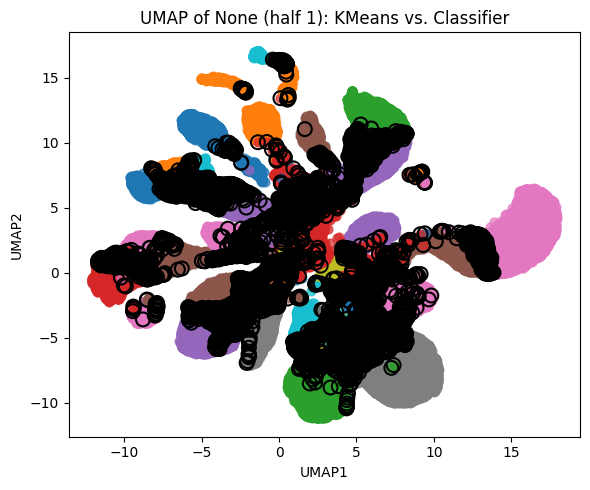

In [75]:
adata_viz = sc.AnnData(
    X=x1ZJ,
    obs=pd.DataFrame({
        'true_cluster': labels1,
        'predicted':   predictedLabels,
        'correct':     labels1 == predictedLabels
    }, index=cells1)
)

#compute neighbors + UMAP on the latent coords
sc.pp.neighbors(adata_viz, use_rep='X', n_neighbors=15)
sc.tl.umap(adata_viz, min_dist=0.3)

#extract UMAP coordinates and metadata
umap = adata_viz.obsm['X_umap']
true = adata_viz.obs['true_cluster'].astype(int)
correct = adata_viz.obs['correct']

#set up plot
plt.figure(figsize=(6,5))

#plot each true cluster
for cl in np.unique(true):
    mask = true == cl
    plt.scatter(
        umap[mask,0], umap[mask,1],
        label=f'Cluster {cl}',
        s=40,
        alpha=0.7
    )

#overlay misclassified cells as open black circles
mis = ~correct
plt.scatter(
    umap[mis,0], umap[mis,1],
    facecolors='none',
    edgecolors='k',
    s=100,
    linewidths=1.5,
    label='Misclassified'
)

#plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=False)
plt.title(f"UMAP of {TARGET_CELL_TYPE} (half 1): KMeans vs. Classifier")
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

## 9. Store Experiment Results to CSV

In [58]:
import os
import pandas as pd

#build a dict for this run’s results
jointEntry = {
    "modality": "joint",
    "n_clusters": N_CLUSTERS,
    "accuracy": accJoint,
}

GEEntry = {
    "modality": "gene expression",
    "n_clusters": N_CLUSTERS,
    "accuracy": accGE,
}

SplEntry = {
    "modality": "splicing",
    "n_clusters": N_CLUSTERS,
    "accuracy": accSpl,
}

#if the file exists, load and append, otherwise create a new DataFrame
if os.path.exists(RESULTS_CSV):
    df = pd.read_csv(RESULTS_CSV)
    df = pd.concat([df, pd.DataFrame([jointEntry, GEEntry, SplEntry])], ignore_index=True)
else:
    df = pd.DataFrame([jointEntry, GEEntry, SplEntry])

#write back to CSV
df.to_csv(RESULTS_CSV, index=False)
print(f"Results appended to {RESULTS_CSV}")

Results appended to /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/results/results.csv


## Run experiments (with varying K)

In [76]:
# --- K‐means on half1 joint latent space

CLUSTER_NUMBERS = [2, 3, 4, 5, 7, 10, 20, 30, 40, 50, 100, 200]

for k in CLUSTER_NUMBERS:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels1 = km.fit_predict(x1ZJ)
    labels2 = km.predict(x2ZJ)  # assign half2's joint latent space using nearest centroid

    clfJoint = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
    clfJoint.fit(x2ZJ, labels2)
    pred1Joint = clfJoint.predict(x1ZJ)

    clfGE = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
    clfGE.fit(x2ZG, labels2)
    pred1GE = clfGE.predict(x1ZJ)

    clfSpl = LogisticRegression(max_iter=200, random_state=RANDOM_SEED)
    clfSpl.fit(x2ZS, labels2)
    pred1Spl = clfSpl.predict(x1ZJ)

    accJoint = accuracy_score(labels1, pred1Joint)
    accGE = accuracy_score(labels1, pred1GE)
    accSpl = accuracy_score(labels1, pred1Spl)

    print(f"ACC: JOINT, k = {k}: {accJoint:.3f}, Expression, k = {k}: {accGE:.3f}, Splicing, k = {k}: {accSpl:.3f}")


    jointEntry = {
        "modality": "joint",
        "n_clusters": k,
        "accuracy": accJoint,
    }

    GEEntry = {
        "modality": "gene expression",
        "n_clusters": k,
        "accuracy": accGE,
    }

    SplEntry = {
        "modality": "splicing",
        "n_clusters": k,
        "accuracy": accSpl,
    }

    #if the file exists, load and append, otherwise create a new DataFrame
    if os.path.exists(RESULTS_CSV):
        df = pd.read_csv(RESULTS_CSV)
        df = pd.concat([df, pd.DataFrame([jointEntry, GEEntry, SplEntry])], ignore_index=True)
    else:
        df = pd.DataFrame([jointEntry, GEEntry, SplEntry])

    #write back to CSV
    df.to_csv(RESULTS_CSV, index=False)

ACC: JOINT, k = 2: 0.997, Expression, k = 2: 0.997, Splicing, k = 2: 0.996
ACC: JOINT, k = 3: 0.992, Expression, k = 3: 0.992, Splicing, k = 3: 0.990
ACC: JOINT, k = 4: 0.990, Expression, k = 4: 0.989, Splicing, k = 4: 0.989
ACC: JOINT, k = 5: 0.986, Expression, k = 5: 0.985, Splicing, k = 5: 0.986
ACC: JOINT, k = 7: 0.983, Expression, k = 7: 0.983, Splicing, k = 7: 0.981
ACC: JOINT, k = 10: 0.981, Expression, k = 10: 0.981, Splicing, k = 10: 0.981
ACC: JOINT, k = 20: 0.962, Expression, k = 20: 0.961, Splicing, k = 20: 0.961
ACC: JOINT, k = 30: 0.912, Expression, k = 30: 0.912, Splicing, k = 30: 0.908
ACC: JOINT, k = 40: 0.868, Expression, k = 40: 0.868, Splicing, k = 40: 0.865
ACC: JOINT, k = 50: 0.837, Expression, k = 50: 0.835, Splicing, k = 50: 0.833
ACC: JOINT, k = 100: 0.634, Expression, k = 100: 0.641, Splicing, k = 100: 0.623
ACC: JOINT, k = 200: 0.374, Expression, k = 200: 0.372, Splicing, k = 200: 0.373


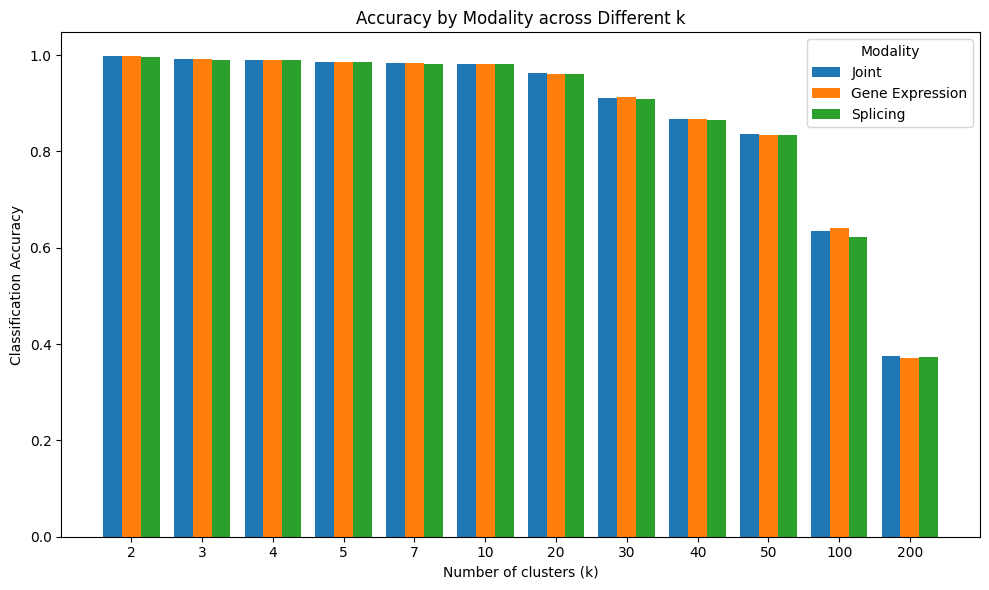

In [77]:
# 1. Read the CSV
df = pd.read_csv(RESULTS_CSV)

# 2. Map raw modality names to nicer titles
df['Modality'] = df['modality'].map({
    'joint': 'Joint',
    'gene expression': 'Gene Expression',
    'splicing': 'Splicing'
})

# 3. Pivot into wide form: index=k, columns=Modality, values=accuracy
pivot = df.pivot(index='n_clusters', columns='Modality', values='accuracy')

order = ['Joint', 'Gene Expression', 'Splicing']
pivot = pivot.reindex(columns=order)
modalities = order

# 4. Plot settings
plt.figure(figsize=(10, 6))
k_values    = pivot.index.values
n_modal     = len(modalities)
bar_width   = 0.8 / n_modal
indices     = np.arange(len(k_values))

# 5. Draw grouped bars
for i, mod in enumerate(modalities):
    plt.bar(
        indices + i * bar_width,
        pivot[mod].values,
        width=bar_width,
        label=mod
    )

# 6. Labels, legend, and ticks
plt.xticks(
    indices + bar_width * (n_modal - 1) / 2,
    k_values
)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy by Modality across Different k')
plt.legend(title='Modality', loc='best')
plt.tight_layout()
plt.show()
